In [1]:
import torch
import torch.nn.functional as F

from captum.attr import visualization as viz

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from ImgTransformer import ImgTransformer
from Models import getModels
from CaptumMethods import CaptumMethods
from tqdm.notebook import tqdm

!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
models_dict = getModels()
img_transformer = ImgTransformer()
captum_methods = CaptumMethods()
default_cmap = plt.get_cmap('jet')

C:\Users\jeman\Anaconda3\envs\trail_workshop_clean_deepdream\lib\site-packages\pytorch_lightning\core\saving.py:209: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['non_linear_evaluator.block_forward.2.weight', 'non_linear_evaluator.block_forward.2.bias']
  rank_zero_warn(


## Attributions on test set

In [8]:
def computeAttribution(model, model_name, method_name, img_path, show_img=True):
    if 'swav' not in model_name:
        if 'crop' in model_name:
            res = img_transformer.get_transformed_img(img_path, normalize=True, crop=True)
        else:
            res = img_transformer.get_transformed_img(img_path, normalize=False, crop=False)
        img, converted_img, transformed_img, input_ = res

        if 'swav' in model_name:
            current_model = lambda i: model(i)[1]
        else:
            current_model = model
        captum_methods.set_method(current_model, method_name)

        with torch.no_grad():
            output = current_model(input_)
        output = F.softmax(output, dim=1)
        _, target = torch.topk(output, 1)

        attributions = captum_methods.attribute(input_, target)

        # params: https://captum.ai/api/utilities.html#visualization
        title = '__'.join([model_name, method_name, str.replace(img_path[3:], '/', '_')])
        if show_img: print(title)
        fig, _ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                                   np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                                   ["original_image", "heat_map"],
                                                   ["all", "absolute_value"],
                                                   cmap=default_cmap,
                                                   show_colorbar=True,
                                                   use_pyplot= show_img)
        fig.savefig('./results/' + title)
        #return attributions.squeeze().cpu().detach().numpy(), fig, title, transformed_img.squeeze().cpu().detach().numpy()
        return attributions, fig, title, transformed_img

def computeAndShowResults(method_names, img_paths):
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
        
    for method_name in method_names:
        print('METHOD', method_name)
        for img_path in img_paths:
            print('IMAGE', img_path)
            for model_name, model in models_dict.items():
                print('MODEL NAME', model_name)
                _ = computeAttribution(model, model_name, method_name, img_path, show_img=True)
            print()
        print()
        print()
        print()
        
def computeAndReturnResults(method_names, img_paths):
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    
    attr_dict = {}
    fig_dict = {}
    transformed_img_dict = {}
    
    for img_path in tqdm(img_paths):
        for method_name in method_names:
            for model_name, model in models_dict.items():
                res = computeAttribution(model, model_name, method_name, img_path, show_img=False)
                if res:
                    attr, fig, title, transformed_img = res
                    attr_dict[title] = attr
                    #fig_dict[title] = fig
                    transformed_img_dict[title] = transformed_img
    return attr_dict, fig_dict, transformed_img_dict


In [9]:
test_dir_path = '../pneumonia/chest_xray/test/'
pneumonia_dir_path = test_dir_path + 'PNEUMONIA/'
img_paths = [pneumonia_dir_path + img_path for img_path in os.listdir(pneumonia_dir_path)]
normal_dir_path = test_dir_path + 'NORMAL/'
img_paths += [normal_dir_path + img_path for img_path in os.listdir(normal_dir_path)]

In [11]:
#method_names = ['GuidedBackprop', 'Deconvolution', 'Saliency', 'GuidedGradCam']
method_names = ['GuidedBackprop']
attr_dict, _, transformed_img_dict = computeAndReturnResults(method_names, img_paths)

  0%|          | 0/624 [00:00<?, ?it/s]

In [12]:
def computeMeans(attr_dict, transformed_img_dict, method_name, pneumonia=True, crop=True):
    pneumonia_condition = lambda key: (pneumonia and 'PNEUMONIA' in key) or (not pneumonia and 'PNEUMONIA' not in key)
    crop_condition = lambda key: (crop and 'crop' in key) or (not crop and 'crop' not in key)
    global_condition = lambda key: pneumonia_condition(key) and crop_condition(key) and method_name in key
    
    attr_list = [value.squeeze().cpu().detach().numpy() for key, value in attr_dict.items() if global_condition(key)]
    transformed_img_list = [value.squeeze().cpu().detach().numpy() for key, value in transformed_img_dict.items() if global_condition(key)]

    attr_mean = attr_list[0]
    transformed_img_mean = transformed_img_list[0]
    for i in range(1, len(attr_list)):
        attr_mean += attr_list[i]
        transformed_img_mean += transformed_img_list[i]

    attr_mean /= len(attr_list)
    transformed_img_mean /= len(attr_list)
    
    return attr_mean, transformed_img_mean

GuidedBackprop


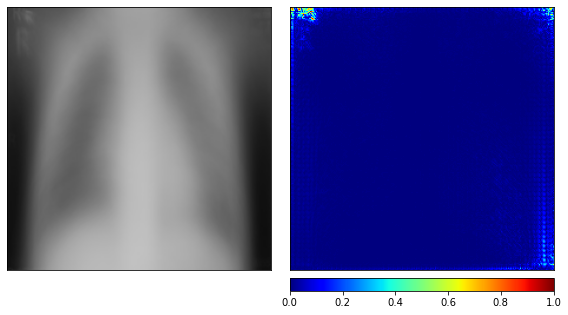

In [13]:
# Pneumonia and not cropped images
for method_name in ['GuidedBackprop']:#['GuidedBackprop', 'Deconvolution', 'Saliency', 'GuidedGradCam']:
    print(method_name)
    attr_mean, transformed_img_mean = computeMeans(attr_dict, transformed_img_dict, method_name, pneumonia=True, crop=False)
    fig, _ = viz.visualize_image_attr_multiple(np.transpose(attr_mean, (1,2,0)),
                                               np.transpose(transformed_img_mean, (1,2,0)),
                                               ["original_image", "heat_map"],
                                               ["all", "absolute_value"],
                                               cmap=default_cmap,
                                               show_colorbar=True)
    fig.savefig('./results/MEAN' + method_name + '_pneumonia_not_cropped.jpg')

GuidedBackprop


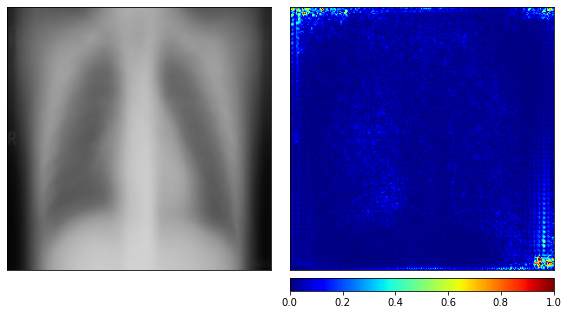

In [14]:
# Normal and not cropped images
for method_name in ['GuidedBackprop']:#['GuidedBackprop', 'Deconvolution', 'Saliency', 'GuidedGradCam']:
    print(method_name)
    attr_mean, transformed_img_mean = computeMeans(attr_dict, transformed_img_dict, method_name, pneumonia=False, crop=False)
    fig, _ = viz.visualize_image_attr_multiple(np.transpose(attr_mean, (1,2,0)),
                                               np.transpose(transformed_img_mean, (1,2,0)),
                                               ["original_image", "heat_map"],
                                               ["all", "absolute_value"],
                                               cmap=default_cmap,
                                               show_colorbar=True)
    fig.savefig('./results/MEAN' + method_name + '_normal_not_cropped.jpg')

GuidedBackprop


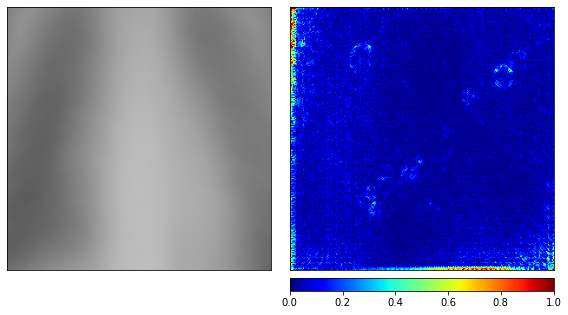

In [15]:
# Pneumonia and cropped images
for method_name in ['GuidedBackprop']:#['GuidedBackprop', 'Deconvolution', 'Saliency', 'GuidedGradCam']:
    print(method_name)
    attr_mean, transformed_img_mean = computeMeans(attr_dict, transformed_img_dict, method_name, pneumonia=True, crop=True)
    fig, _ = viz.visualize_image_attr_multiple(np.transpose(attr_mean, (1,2,0)),
                                               np.transpose(transformed_img_mean, (1,2,0)),
                                               ["original_image", "heat_map"],
                                               ["all", "absolute_value"],
                                               cmap=default_cmap,
                                               show_colorbar=True)
    fig.savefig('./results/MEAN' + method_name + '_pneumonia_cropped.jpg')

GuidedBackprop


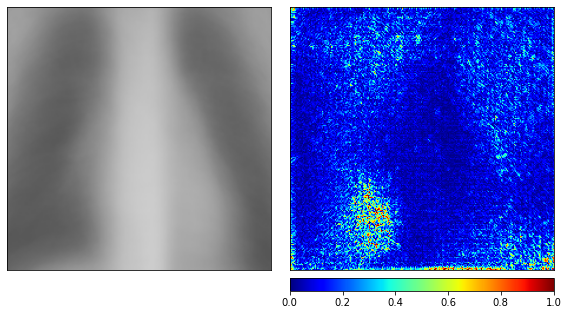

In [16]:
# Normal and cropped images
for method_name in ['GuidedBackprop']:#['GuidedBackprop', 'Deconvolution', 'Saliency', 'GuidedGradCam']:
    print(method_name)
    attr_mean, transformed_img_mean = computeMeans(attr_dict, transformed_img_dict, method_name, pneumonia=False, crop=True)
    fig, _ = viz.visualize_image_attr_multiple(np.transpose(attr_mean, (1,2,0)),
                                               np.transpose(transformed_img_mean, (1,2,0)),
                                               ["original_image", "heat_map"],
                                               ["all", "absolute_value"],
                                               cmap=default_cmap,
                                               show_colorbar=True)
    fig.savefig('./results/MEAN' + method_name + '_normal_cropped.jpg')

## Attributions on test set (reverse crop)

Cropped images to models trained with not cropped images and inversely

In [17]:
def computeAttribution(model, model_name, method_name, img_path, show_img=True):
    if 'swav' not in model_name:
        if 'crop' in model_name:
            res = img_transformer.get_transformed_img(img_path, normalize=True, crop=False)
        else:
            res = img_transformer.get_transformed_img(img_path, normalize=False, crop=True)
        img, converted_img, transformed_img, input_ = res

        if 'swav' in model_name:
            current_model = lambda i: model(i)[1]
        else:
            current_model = model
        captum_methods.set_method(current_model, method_name)

        with torch.no_grad():
            output = current_model(input_)
        output = F.softmax(output, dim=1)
        _, target = torch.topk(output, 1)

        attributions = captum_methods.attribute(input_, target)

        # params: https://captum.ai/api/utilities.html#visualization
        title = '__'.join([model_name, method_name, str.replace(img_path[3:], '/', '_')])
        if show_img: print(title)
        fig, _ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                                   np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                                   ["original_image", "heat_map"],
                                                   ["all", "absolute_value"],
                                                   cmap=default_cmap,
                                                   show_colorbar=True,
                                                   use_pyplot= show_img)
        fig.savefig('./results_reverse/' + title)
        #return attributions.squeeze().cpu().detach().numpy(), fig, title, transformed_img.squeeze().cpu().detach().numpy()
        return attributions, fig, title, transformed_img

def computeAndShowResults(method_names, img_paths):
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
        
    for method_name in method_names:
        print('METHOD', method_name)
        for img_path in img_paths:
            print('IMAGE', img_path)
            for model_name, model in models_dict.items():
                print('MODEL NAME', model_name)
                _ = computeAttribution(model, model_name, method_name, img_path, show_img=True)
            print()
        print()
        print()
        print()
        
def computeAndReturnResults(method_names, img_paths):
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    
    attr_dict = {}
    fig_dict = {}
    transformed_img_dict = {}
    
    for img_path in tqdm(img_paths):
        for method_name in method_names:
            for model_name, model in models_dict.items():
                res = computeAttribution(model, model_name, method_name, img_path, show_img=False)
                if res:
                    attr, fig, title, transformed_img = res
                    attr_dict[title] = attr
                    #fig_dict[title] = fig
                    transformed_img_dict[title] = transformed_img
    return attr_dict, fig_dict, transformed_img_dict


In [18]:
test_dir_path = '../pneumonia/chest_xray/test/'
pneumonia_dir_path = test_dir_path + 'PNEUMONIA/'
img_paths = [pneumonia_dir_path + img_path for img_path in os.listdir(pneumonia_dir_path)]
normal_dir_path = test_dir_path + 'NORMAL/'
img_paths += [normal_dir_path + img_path for img_path in os.listdir(normal_dir_path)]

In [20]:
#method_names = ['GuidedBackprop', 'Deconvolution', 'Saliency', 'GuidedGradCam']
method_names = ['GuidedBackprop']
attr_dict, _, transformed_img_dict = computeAndReturnResults(method_names, img_paths)

  0%|          | 0/624 [00:00<?, ?it/s]

In [21]:
def computeMeans(attr_dict, transformed_img_dict, method_name, pneumonia=True, crop=True):
    pneumonia_condition = lambda key: (pneumonia and 'PNEUMONIA' in key) or (not pneumonia and 'PNEUMONIA' not in key)
    crop_condition = lambda key: (crop and 'crop' in key) or (not crop and 'crop' not in key)
    global_condition = lambda key: pneumonia_condition(key) and crop_condition(key) and method_name in key
    
    attr_list = [value.squeeze().cpu().detach().numpy() for key, value in attr_dict.items() if global_condition(key)]
    transformed_img_list = [value.squeeze().cpu().detach().numpy() for key, value in transformed_img_dict.items() if global_condition(key)]

    attr_mean = attr_list[0]
    transformed_img_mean = transformed_img_list[0]
    for i in range(1, len(attr_list)):
        attr_mean += attr_list[i]
        transformed_img_mean += transformed_img_list[i]

    attr_mean /= len(attr_list)
    transformed_img_mean /= len(attr_list)
    
    return attr_mean, transformed_img_mean

GuidedBackprop


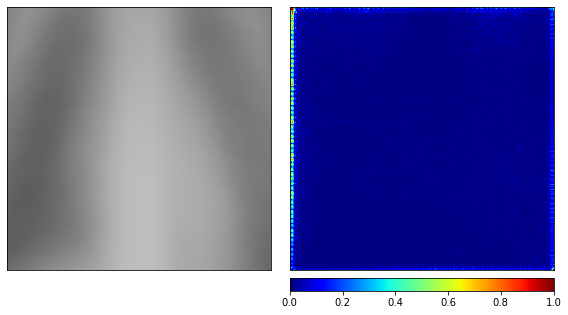

In [22]:
# Pneumonia and not cropped images
for method_name in ['GuidedBackprop']:#['GuidedBackprop', 'Deconvolution', 'Saliency', 'GuidedGradCam']:
    print(method_name)
    attr_mean, transformed_img_mean = computeMeans(attr_dict, transformed_img_dict, method_name, pneumonia=True, crop=False)
    fig, _ = viz.visualize_image_attr_multiple(np.transpose(attr_mean, (1,2,0)),
                                               np.transpose(transformed_img_mean, (1,2,0)),
                                               ["original_image", "heat_map"],
                                               ["all", "absolute_value"],
                                               cmap=default_cmap,
                                               show_colorbar=True)
    fig.savefig('./results_reverse/MEAN' + method_name + '_pneumonia_not_cropped.jpg')

GuidedBackprop


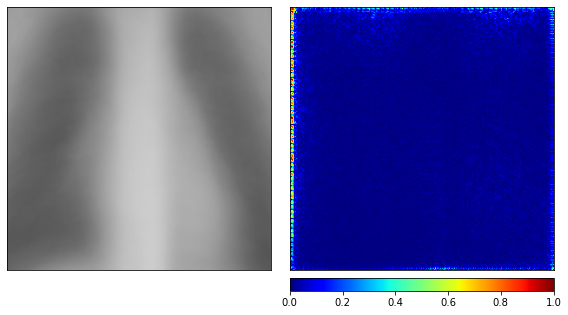

In [23]:
# Normal and not cropped images
for method_name in ['GuidedBackprop']:#['GuidedBackprop', 'Deconvolution', 'Saliency', 'GuidedGradCam']:
    print(method_name)
    attr_mean, transformed_img_mean = computeMeans(attr_dict, transformed_img_dict, method_name, pneumonia=False, crop=False)
    fig, _ = viz.visualize_image_attr_multiple(np.transpose(attr_mean, (1,2,0)),
                                               np.transpose(transformed_img_mean, (1,2,0)),
                                               ["original_image", "heat_map"],
                                               ["all", "absolute_value"],
                                               cmap=default_cmap,
                                               show_colorbar=True)
    fig.savefig('./results_reverse/MEAN' + method_name + '_normal_not_cropped.jpg')

GuidedBackprop


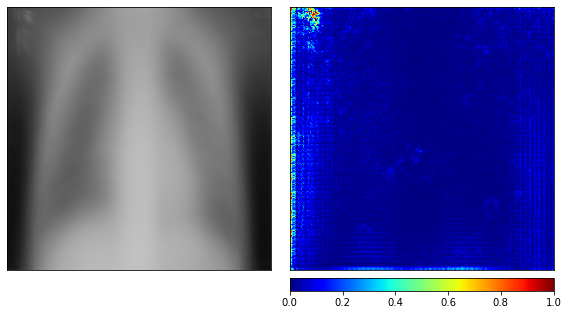

In [24]:
# Pneumonia and cropped images
for method_name in ['GuidedBackprop']:#['GuidedBackprop', 'Deconvolution', 'Saliency', 'GuidedGradCam']:
    print(method_name)
    attr_mean, transformed_img_mean = computeMeans(attr_dict, transformed_img_dict, method_name, pneumonia=True, crop=True)
    fig, _ = viz.visualize_image_attr_multiple(np.transpose(attr_mean, (1,2,0)),
                                               np.transpose(transformed_img_mean, (1,2,0)),
                                               ["original_image", "heat_map"],
                                               ["all", "absolute_value"],
                                               cmap=default_cmap,
                                               show_colorbar=True)
    fig.savefig('./results_reverse/MEAN' + method_name + '_pneumonia_cropped.jpg')

GuidedBackprop


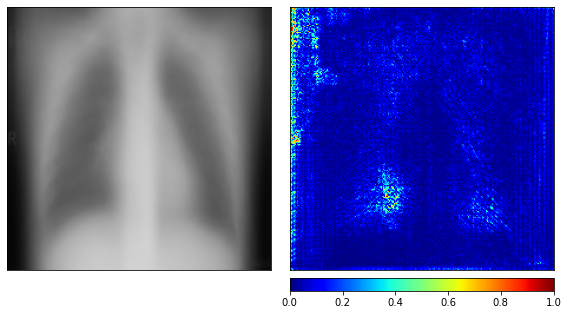

In [25]:
# Normal and cropped images
for method_name in ['GuidedBackprop']:#['GuidedBackprop', 'Deconvolution', 'Saliency', 'GuidedGradCam']:
    print(method_name)
    attr_mean, transformed_img_mean = computeMeans(attr_dict, transformed_img_dict, method_name, pneumonia=False, crop=True)
    fig, _ = viz.visualize_image_attr_multiple(np.transpose(attr_mean, (1,2,0)),
                                               np.transpose(transformed_img_mean, (1,2,0)),
                                               ["original_image", "heat_map"],
                                               ["all", "absolute_value"],
                                               cmap=default_cmap,
                                               show_colorbar=True)
    fig.savefig('./results_reverse/MEAN' + method_name + '_normal_cropped.jpg')

## Attributions on a cluster (cf. report)

In [3]:
def computeAttribution(model, model_name, method_name, img_path, show_img=True):
    if 'swav' not in model_name:
        if 'crop' in model_name:
            res = img_transformer.get_transformed_img(img_path, normalize=True, crop=True)
        else:
            res = img_transformer.get_transformed_img(img_path, normalize=False, crop=False)
        img, converted_img, transformed_img, input_ = res

        if 'swav' in model_name:
            current_model = lambda i: model(i)[1]
        else:
            current_model = model
        captum_methods.set_method(current_model, method_name)

        with torch.no_grad():
            output = current_model(input_)
        output = F.softmax(output, dim=1)
        _, target = torch.topk(output, 1)

        attributions = captum_methods.attribute(input_, target)

        # params: https://captum.ai/api/utilities.html#visualization
        title = '__'.join([model_name, method_name, str.replace(img_path[3:], '/', '_')])
        if show_img: print(title)
        fig, _ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                                   np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                                   ["original_image", "heat_map"],
                                                   ["all", "absolute_value"],
                                                   cmap=default_cmap,
                                                   show_colorbar=True,
                                                   use_pyplot= show_img)
        fig.savefig('./results_cluster/' + title)
        #return attributions.squeeze().cpu().detach().numpy(), fig, title, transformed_img.squeeze().cpu().detach().numpy()
        return attributions, fig, title, transformed_img

def computeAndShowResults(method_names, img_paths):
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
        
    for method_name in method_names:
        print('METHOD', method_name)
        for img_path in img_paths:
            print('IMAGE', img_path)
            for model_name, model in models_dict.items():
                print('MODEL NAME', model_name)
                _ = computeAttribution(model, model_name, method_name, img_path, show_img=True)
            print()
        print()
        print()
        print()
        
def computeAndReturnResults(method_names, img_paths):
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    
    attr_dict = {}
    fig_dict = {}
    transformed_img_dict = {}
    
    for img_path in tqdm(img_paths):
        for method_name in method_names:
            for model_name, model in models_dict.items():
                res = computeAttribution(model, model_name, method_name, img_path, show_img=False)
                if res:
                    attr, fig, title, transformed_img = res
                    attr_dict[title] = attr
                    #fig_dict[title] = fig
                    transformed_img_dict[title] = transformed_img
    return attr_dict, fig_dict, transformed_img_dict


In [5]:
img_partial_paths = ['chest_xray/test/PNEUMONIA/person109_bacteria_528.jpeg',
 'chest_xray/test/PNEUMONIA/person1661_virus_2872.jpeg',
 'chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg',
 'chest_xray/test/PNEUMONIA/person94_bacteria_456.jpeg',
 'chest_xray/test/PNEUMONIA/person141_bacteria_677.jpeg',
 'chest_xray/test/PNEUMONIA/person118_bacteria_560.jpeg',
 'chest_xray/test/PNEUMONIA/person80_bacteria_392.jpeg',
 'chest_xray/test/NORMAL/NORMAL2-IM-0343-0001.jpeg',
 'chest_xray/test/PNEUMONIA/person80_bacteria_389.jpeg',
 'chest_xray/test/NORMAL/IM-0022-0001.jpeg',
 'chest_xray/test/NORMAL/NORMAL2-IM-0249-0001.jpeg',
 'chest_xray/test/PNEUMONIA/person80_bacteria_391.jpeg',
 'chest_xray/test/PNEUMONIA/person133_bacteria_638.jpeg',
 'chest_xray/test/PNEUMONIA/person81_bacteria_396.jpeg',
 'chest_xray/test/PNEUMONIA/person122_bacteria_584.jpeg',
 'chest_xray/test/PNEUMONIA/person161_bacteria_762.jpeg',
 'chest_xray/test/PNEUMONIA/person92_bacteria_451.jpeg',
 'chest_xray/test/PNEUMONIA/person133_bacteria_633.jpeg',
 'chest_xray/test/PNEUMONIA/person1661_virus_2873.jpeg',
 'chest_xray/test/PNEUMONIA/person8_virus_28.jpeg',
 'chest_xray/test/PNEUMONIA/person78_bacteria_385.jpeg',
 'chest_xray/test/NORMAL/NORMAL2-IM-0373-0001.jpeg',
 'chest_xray/test/PNEUMONIA/person161_bacteria_757.jpeg',
 'chest_xray/test/PNEUMONIA/person14_virus_44.jpeg',
 'chest_xray/test/PNEUMONIA/person130_bacteria_628.jpeg',
 'chest_xray/test/PNEUMONIA/person142_bacteria_682.jpeg',
 'chest_xray/test/PNEUMONIA/person143_bacteria_687.jpeg',
 'chest_xray/test/PNEUMONIA/person82_bacteria_403.jpeg']

img_paths = ['../pneumonia/' + path for path in img_partial_paths]

In [8]:
#method_names = ['GuidedBackprop', 'Deconvolution', 'Saliency', 'GuidedGradCam']
method_names = ['GuidedBackprop']
attr_dict, _, transformed_img_dict = computeAndReturnResults(method_names, img_paths)

  0%|          | 0/28 [00:00<?, ?it/s]

In [9]:
def computeMeans(attr_dict, transformed_img_dict, method_name, pneumonia=True, crop=True):
    pneumonia_condition = lambda key: (pneumonia and 'PNEUMONIA' in key) or (not pneumonia and 'PNEUMONIA' not in key)
    crop_condition = lambda key: (crop and 'crop' in key) or (not crop and 'crop' not in key)
    global_condition = lambda key: pneumonia_condition(key) and crop_condition(key) and method_name in key
    
    attr_list = [value.squeeze().cpu().detach().numpy() for key, value in attr_dict.items() if global_condition(key)]
    transformed_img_list = [value.squeeze().cpu().detach().numpy() for key, value in transformed_img_dict.items() if global_condition(key)]

    attr_mean = attr_list[0]
    transformed_img_mean = transformed_img_list[0]
    for i in range(1, len(attr_list)):
        attr_mean += attr_list[i]
        transformed_img_mean += transformed_img_list[i]

    attr_mean /= len(attr_list)
    transformed_img_mean /= len(attr_list)
    
    return attr_mean, transformed_img_mean

GuidedBackprop


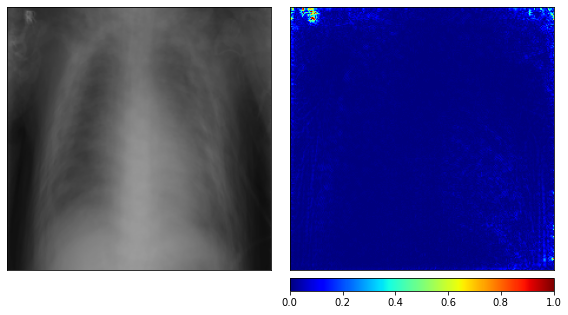

In [14]:
# Pneumonia and not cropped images
for method_name in ['GuidedBackprop']:#['GuidedBackprop', 'Deconvolution', 'Saliency', 'GuidedGradCam']:
    print(method_name)
    attr_mean, transformed_img_mean = computeMeans(attr_dict, transformed_img_dict, method_name, pneumonia=True, crop=False)
    fig, _ = viz.visualize_image_attr_multiple(np.transpose(attr_mean, (1,2,0)),
                                               np.transpose(transformed_img_mean, (1,2,0)),
                                               ["original_image", "heat_map"],
                                               ["all", "absolute_value"],
                                               cmap=default_cmap,
                                               show_colorbar=True)
    fig.savefig('./results_cluster/MEAN' + method_name + '_pneumonia_not_cropped.jpg')

GuidedBackprop


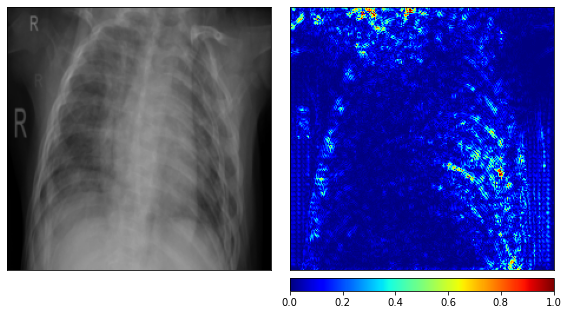

In [15]:
# Normal and not cropped images
for method_name in ['GuidedBackprop']:#['GuidedBackprop', 'Deconvolution', 'Saliency', 'GuidedGradCam']:
    print(method_name)
    attr_mean, transformed_img_mean = computeMeans(attr_dict, transformed_img_dict, method_name, pneumonia=False, crop=False)
    fig, _ = viz.visualize_image_attr_multiple(np.transpose(attr_mean, (1,2,0)),
                                               np.transpose(transformed_img_mean, (1,2,0)),
                                               ["original_image", "heat_map"],
                                               ["all", "absolute_value"],
                                               cmap=default_cmap,
                                               show_colorbar=True)
    fig.savefig('./results_cluster/MEAN' + method_name + '_normal_not_cropped.jpg')

GuidedBackprop


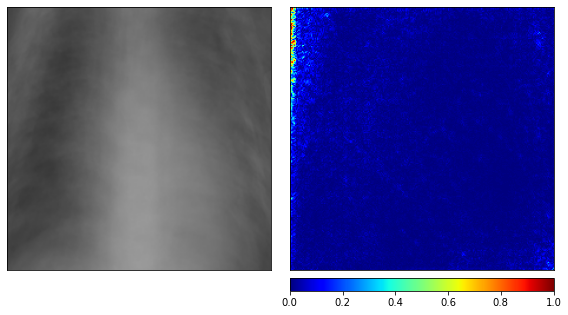

In [16]:
# Pneumonia and cropped images
for method_name in ['GuidedBackprop']:#['GuidedBackprop', 'Deconvolution', 'Saliency', 'GuidedGradCam']:
    print(method_name)
    attr_mean, transformed_img_mean = computeMeans(attr_dict, transformed_img_dict, method_name, pneumonia=True, crop=True)
    fig, _ = viz.visualize_image_attr_multiple(np.transpose(attr_mean, (1,2,0)),
                                               np.transpose(transformed_img_mean, (1,2,0)),
                                               ["original_image", "heat_map"],
                                               ["all", "absolute_value"],
                                               cmap=default_cmap,
                                               show_colorbar=True)
    fig.savefig('./results_cluster/MEAN' + method_name + '_pneumonia_cropped.jpg')

GuidedBackprop


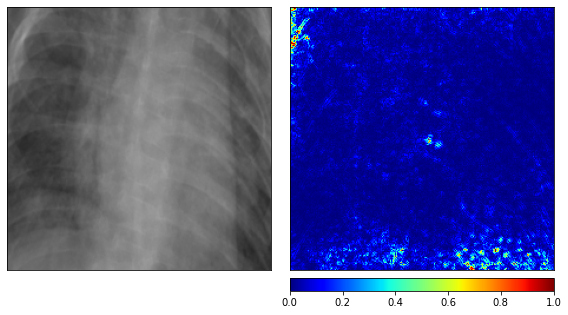

In [17]:
# Normal and cropped images
for method_name in ['GuidedBackprop']:#['GuidedBackprop', 'Deconvolution', 'Saliency', 'GuidedGradCam']:
    print(method_name)
    attr_mean, transformed_img_mean = computeMeans(attr_dict, transformed_img_dict, method_name, pneumonia=False, crop=True)
    fig, _ = viz.visualize_image_attr_multiple(np.transpose(attr_mean, (1,2,0)),
                                               np.transpose(transformed_img_mean, (1,2,0)),
                                               ["original_image", "heat_map"],
                                               ["all", "absolute_value"],
                                               cmap=default_cmap,
                                               show_colorbar=True)
    fig.savefig('./results_cluster/MEAN' + method_name + '_normal_cropped.jpg')